# SuSiE Behavioral Regimes: From Easy to Pathological

SuSiE (Sum of Single Effects) is a fast variational method for Bayesian fine-mapping. Its core algorithm, IBSS (Iterative Bayesian Stepwise Selection), performs coordinate ascent over single-effect components to approximate the posterior over sparse multi-SNP models. This notebook builds intuition for **when a single SuSiE fit is sufficient and when it is not**, by constructing four synthetic scenarios with progressively more challenging LD and signal structure.

Each scenario follows the same experimental design:
- Simulate $X$ ($N=600$, $P=10$) and $y$ with 3 true causal variants at columns 1, 3, 5.
- Fit SuSiE three ways: **(1)** default initialization, **(2)** warm start at the true causal set, **(3)** warm start at a decoy set (columns 2, 4, 6).
- Compare credible sets, ELBOs, and ELBO-softmax ensemble weights across fits.

The key diagnostic question is: **do all three fits land in the same basin?** When they don't, we ask what kind of intervention is needed.

### Terminology

- **Fit** (= variational optimum): The output of one `susie()` call — a specific set of $\alpha$, $\mu$, $\mu^2$ parameters at a local maximum of the ELBO.
- **Basin**: The cluster of discrete SNP configurations that a single fit effectively represents via its alpha distributions. Within a basin, discrete configurations differ by per-component variable swaps — the variation that split alpha vectors capture. Between basins, configurations require coordinated reassignment across multiple components, which independent alpha vectors cannot express. One variational optimum in SuSiE's continuous alpha space corresponds to one basin of the underlying discrete model space.
- **Local/global optimum**: Standard optimization terminology for the ELBO landscape. Each fit converges to a local optimum; different local optima may correspond to different basins.

### Three tiers of resolution

When a single SuSiE fit is unreliable, there are two progressively stronger interventions:

1. **Multi-start selection.** Run SuSiE from multiple initializations (or use `susieR`'s built-in `refine` option, which systematically zeroes out each credible set's prior weights and refits). Keep the single fit with the highest ELBO. This finds the best basin but *commits to one* — it does not express uncertainty across basins.

2. **Ensembling.** Run multiple fits and *aggregate* their PIPs via ELBO-softmax (or other) weights, producing a combined posterior that represents uncertainty across basins.

Multi-start selection is sufficient when the posterior has one clearly dominant basin that the default optimizer simply fails to reach (an *optimizer* problem). Ensembling is necessary when multiple basins are genuinely plausible and discarding any of them would lose information (a *model specification* problem).

### Source of difficulty: AND-of-ORs vs. OR-of-ANDs

SuSiE's variational posterior is a product of $L$ independent single-effect components, each a categorical distribution over $p$ variables. A single fit therefore represents uncertainty with an **AND-of-ORs** structure — each component independently spreads probability mass across alternatives:

$$\text{AND}\big(\text{OR}(1,2),\;\text{OR}(3,4),\;\text{OR}(5,6)\big)$$

This is exactly Scenario 2's structure: each causal/proxy pair is handled by one component's OR, and the components combine independently. No discrete basins form because the per-component choices don't need to be coordinated.

What a single SuSiE fit *cannot* represent is **OR-of-ANDs** uncertainty — "either this complete configuration or that one":

$$\text{OR}\big(\text{AND}(1,3,5),\;\text{AND}(2,4,6)\big)$$

This requires *correlated* choices across components: if component 1 picks from set $A$, components 2 and 3 must follow suit. The independent variational factors cannot express this coupling, so each fit commits to one AND configuration — one basin. This is Scenario 3's structure, and it is a **model-specification barrier** — even a perfect optimizer would land in one basin per fit.

- **Model-specification barrier** (Scenario 3): The true uncertainty is OR-of-ANDs. Each fit commits to one basin; ensembling is needed to represent the outer OR.
- **Optimizer barrier** (Scenario 4): The model *can* represent the correct AND configuration, but IBSS's greedy updates fail to reach it. Multi-start selection suffices.

| Scenario | LD structure | Uncertainty structure | Primary barrier | Single fit | Multi-start selection | Ensemble |
|---|---|---|---|---|---|---|
| 1. Happy path | Independent columns | Single AND | None | OK | OK | OK |
| 2. Within-effect ambiguity | High pairwise $r$ within pairs | AND-of-ORs | None | OK | OK | OK |
| 3. Between-effect ambiguity | Proxy group spans causal subspace | OR-of-ANDs | Model spec | **Fails** | **Fails** | OK |
| 4. Greedy trap | Decoy marginals $>$ true marginals | Single dominant AND | Optimizer | **Fails** | OK | OK |

## Setup

We load `susieR` and define three helpers: `make_init` (warm-start initialization), `plot_pips` (PIP visualization), and `fit_scenario` (runs all three fits with diagnostics).

In [6]:
library(susieR)
library(ggplot2)
library(cowplot)
library(pheatmap)
options(repr.plot.width = 12, repr.plot.height = 9)
set.seed(1)

# Helper: create warm-start init object (L x P matrices for alpha, mu, mu2)
make_init <- function(idx, betas, L, P) {
  alpha <- mu <- mu2 <- matrix(0, L, P)
  alpha[cbind(seq_along(idx), idx)] <- 1
  mu[cbind(seq_along(idx), idx)] <- betas
  mu2[cbind(seq_along(idx), idx)] <- betas^2
  structure(list(alpha = alpha, mu = mu, mu2 = mu2), class = "susie")
}

# Helper: plot PIPs with causal variants highlighted
plot_pips <- function(fit, true_causal, title = "SuSiE PIPs") {
  df <- data.frame(SNP = seq_along(fit$pip), PIP = fit$pip,
                   IsCausal = seq_along(fit$pip) %in% true_causal)
  ggplot(df, aes(x = SNP, y = PIP, color = IsCausal)) +
    geom_point(alpha = 0.6) + scale_color_manual(values = c("black", "red")) +
    theme_minimal() + labs(title = title, x = "SNP Index", y = "PIP")
}

# Helper: fit default + true/decoy warm starts, print all diagnostics, return 4-panel plot
fit_scenario <- function(X, y, g, true_idx, decoy_idx, b_true, title,
                         L = 5, b_decoy = NULL, ...) {
  P <- ncol(X)
  cat("Simulated PVE:", var(g) / var(y), "\n")
  cat("Max |corr| (true):", round(max(abs(cor(X[, true_idx], y))), 4),
      "| (decoy):", round(max(abs(cor(X[, decoy_idx], y))), 4), "\n")
  r2_t <- summary(lm(y ~ X[, true_idx]))$r.squared
  r2_d <- summary(lm(y ~ X[, decoy_idx]))$r.squared
  cat("Joint R2 true:", round(r2_t, 4), "| Joint R2 decoy:", round(r2_d, 4),
      "| PVE_joint_gap (true-decoy):", round(r2_t - r2_d, 4), "\n")

  res_def <- susie(X, y, L = L, ...)
  res_true <- susie(X, y, L = L, s_init = make_init(true_idx, b_true, L, P), ...)
  if (is.null(b_decoy)) {
    b_decoy <- as.numeric(coef(lm(y ~ X[, decoy_idx]))[-1])
    b_decoy <- ifelse(abs(b_decoy) < 1e-6, sign(b_decoy + 1e-12) * 1e-6, b_decoy)
  }
  res_decoy <- susie(X, y, L = L, s_init = make_init(decoy_idx, b_decoy, L, P), ...)

  fits <- list("Default" = res_def, "True warm start" = res_true, "Decoy warm start" = res_decoy)
  for (nm in names(fits)) { cat("\n--- Credible Sets (", nm, ") ---\n"); print(summary(fits[[nm]])$cs) }

  e <- sapply(fits, susie_get_objective)
  cat("\nELBO (Default):", e[1], "\nELBO (True warm start):", e[2],
      "\nELBO (Decoy warm start):", e[3], "\n")
  cat("ELBO gap (True - Default):", e[2] - e[1], "\n")
  cat("ELBO gap (Decoy - Default):", e[3] - e[1], "\n")
  w <- plogis(e[2] - e[3])
  cat("Estimated 2-basin ensemble weights (ELBO-softmax):",
      "True =", round(w, 4), "| Decoy =", round(1 - w, 4), "\n")
  cat("Default decoy-dominant failure:",
      max(res_def$pip[decoy_idx]) > max(res_def$pip[true_idx]) &&
      sum(res_def$pip[decoy_idx]) > sum(res_def$pip[true_idx]), "\n")

  p_corr <- pheatmap(cor(X), display_numbers = TRUE, silent = TRUE,
                     cluster_rows = FALSE, cluster_cols = FALSE,
                     main = paste("Correlation Matrix:", title))$gtable
  cowplot::plot_grid(p_corr,
    plot_pips(res_def, true_idx, paste(title, "- Default")),
    plot_pips(res_true, true_idx, paste(title, "- True warm start")),
    plot_pips(res_decoy, true_idx, paste(title, "- Decoy warm start")), ncol = 2)
}

## Scenario 1: The Happy Path (Independent Columns, Strong Signal)

**Setup:** $X$ has 10 independent columns (no LD), PVE $= 0.8$. True causal effects at columns 1, 3, 5 with $b = (0.8, -0.8, 1.0)$.

**Why this is easy:** With no correlation between columns, each causal variant has a strong, unambiguous marginal association with $y$. There is only one basin — a single AND configuration — and IBSS finds it regardless of initialization.

**What to look for:** All three fits (default, true warm start, decoy warm start) should recover the same credible sets, produce nearly identical ELBOs, and assign ensemble weights close to 50/50 — confirming there is only one basin worth finding.

Simulated PVE: 0.3002835 
Max |corr| (true): 0.4098 | (decoy): 0.0569 
Joint R2 true: 0.3394 | Joint R2 decoy: 0.0063 | PVE_joint_gap (true-decoy): 0.333 

--- Credible Sets ( Default ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   28.77771         1         1        5
2  2   18.18672         1         1        3
3  3   11.24914         1         1        1

--- Credible Sets ( True warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   11.24900         1         1        1
2  2   18.18651         1         1        3
3  3   28.77734         1         1        5

--- Credible Sets ( Decoy warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   28.77771         1         1        5
2  2   18.18672         1         1        3
3  3   11.24914         1         1        1

ELBO (Default): -1357.903 
ELBO (True warm start): -1357.903 
ELBO (Decoy warm start): -1357.903 
ELBO gap (True - Default): -2.155389e-08 
ELBO gap (Decoy - Default): 0 
Estimated 2

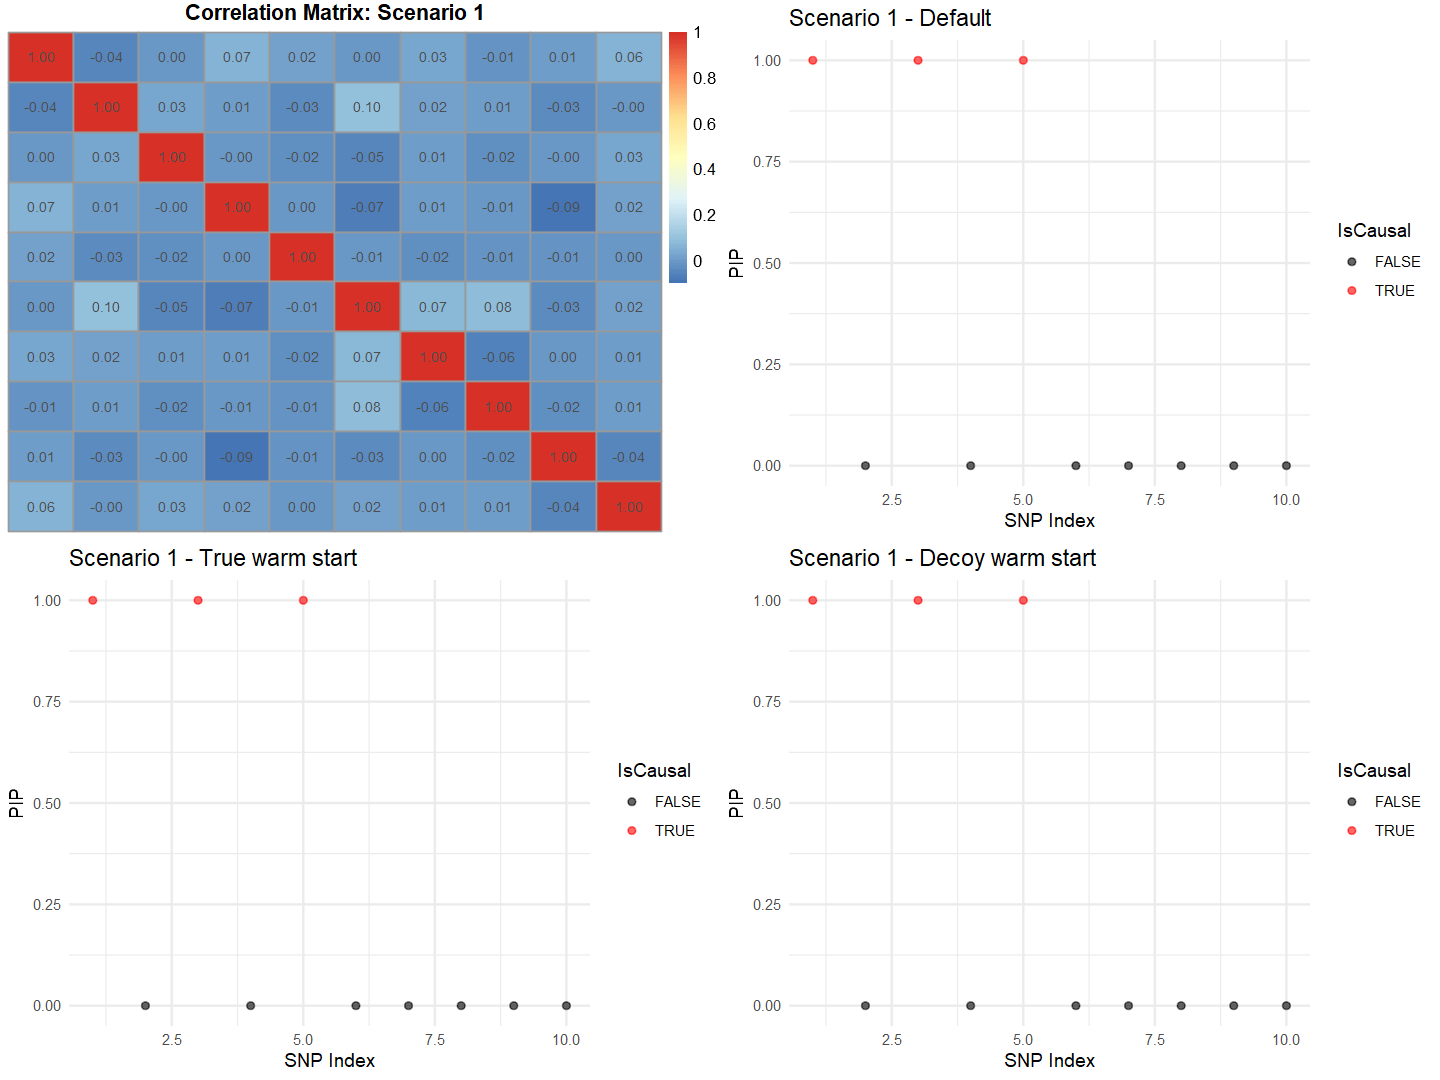

In [33]:
set.seed(42)
N <- 600; P <- 10
X1 <- apply(matrix(runif(N * P), N, P), 2, function(x) scale(rbinom(N, 2, x)))
b1 <- c(0.8, -0.8, 1.0)
g1 <- X1[, c(1, 3, 5)] %*% b1
y1 <- g1 + rnorm(N, sd = sqrt(var(g1) * (1/0.3 - 1)))

fit_scenario(X1, y1, g1, c(1, 3, 5), c(2, 4, 6), b1, "Scenario 1",
             L = 5, estimate_residual_variance = TRUE, estimate_prior_variance = TRUE)

## Scenario 2: Within-Effect Ambiguity (AND-of-ORs)

**Setup:** 3 causal variants at columns 1, 3, 5. Each is paired with a highly correlated proxy at the adjacent column ($r \approx 0.98$): pairs are (1,2), (3,4), (5,6). Columns 7--10 are noise. PVE $= 0.2$ (moderate signal).

**Why SuSiE handles this correctly:** The uncertainty here has an **AND-of-ORs** structure — the true causal model is "one from pair (1,2) AND one from pair (3,4) AND one from pair (5,6)":

$$\text{AND}\big(\text{OR}(1,2),\;\text{OR}(3,4),\;\text{OR}(5,6)\big)$$

This maps directly onto SuSiE's variational family: each effect component independently handles one OR, spreading PIP mass across the correlated pair within a single credible set. The components don't need to coordinate their choices, so only one basin exists and all fits land in it.

**What to look for:** Each CS should contain both the causal variant and its proxy, with PIPs split roughly 50/50, reflecting genuine uncertainty. All three fits should converge to the same basin (same CS membership, similar ELBOs), confirming that high pairwise correlation alone does not create multiple basins — what matters is whether the per-component choices are independent (AND-of-ORs, one basin) or coupled (OR-of-ANDs, multiple basins; see Scenario 3).

Simulated PVE: 0.1995926 
Max |corr| (true): 0.3309 | (decoy): 0.3253 
Joint R2 true: 0.2493 | Joint R2 decoy: 0.2434 | PVE_joint_gap (true-decoy): 0.0059 

--- Credible Sets ( Default ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  2  11.569541 0.9635241 0.9635241      5,6
2  1  17.932095 0.9602324 0.9602324      3,4
3  3   9.348506 0.9576287 0.9576287      1,2

--- Credible Sets ( True warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  3  11.569183 0.9635241 0.9635241      5,6
2  2  17.931245 0.9602324 0.9602324      3,4
3  1   9.348758 0.9576287 0.9576287      1,2

--- Credible Sets ( Decoy warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  3  11.569284 0.9635241 0.9635241      5,6
2  2  17.931409 0.9602324 0.9602324      3,4
3  1   9.348792 0.9576287 0.9576287      1,2

ELBO (Default): -1580.995 
ELBO (True warm start): -1580.995 
ELBO (Decoy warm start): -1580.995 
ELBO gap (True - Default): -1.537421e-07 
ELBO gap (Decoy - Default): -9.099404e-08

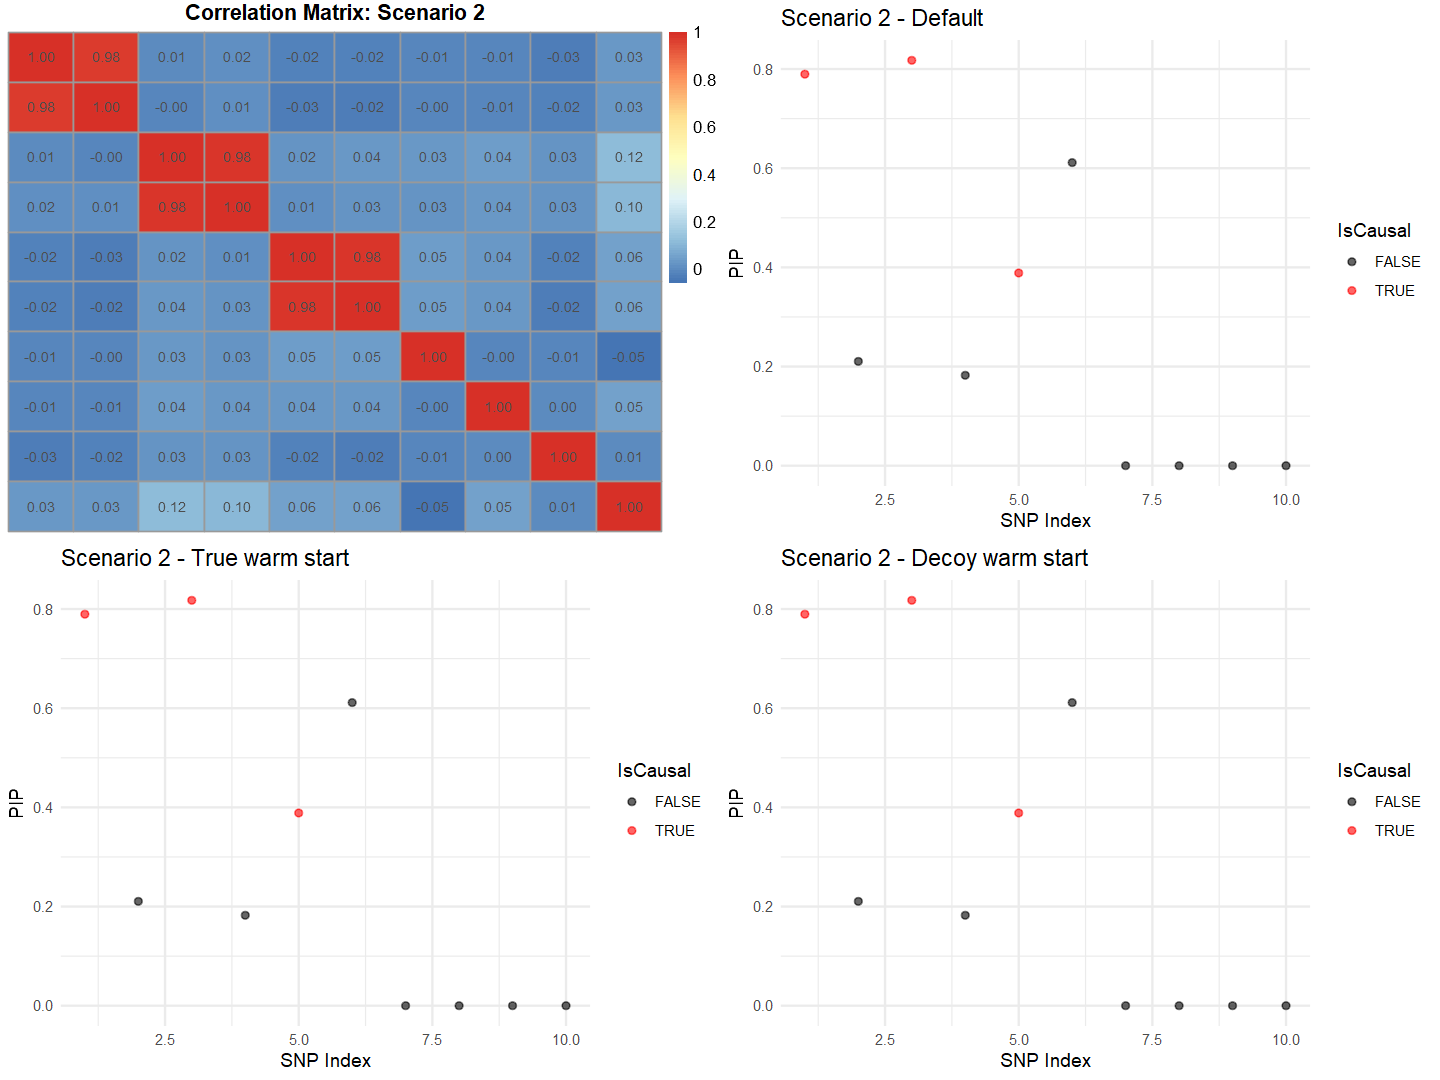

In [8]:
set.seed(42)
N <- 600; P <- 10
X2 <- matrix(0, N, P)
for (i in seq(1, 6, 2)) {
  X2[, i] <- rnorm(N)
  X2[, i + 1] <- 0.98 * X2[, i] + sqrt(1 - 0.98^2) * rnorm(N)
}
X2[, 7:P] <- rnorm(N * 4)
X2 <- scale(X2)

b2 <- c(1, -1, 1)
g2 <- X2[, c(1, 3, 5)] %*% b2
y2 <- g2 + rnorm(N, sd = sqrt(var(g2) * (1/0.2 - 1)))

fit_scenario(X2, y2, g2, c(1, 3, 5), c(2, 4, 6), b2, "Scenario 2", L = 5)

## Scenario 3: Between-Effect Ambiguity (OR-of-ANDs)

**Setup:** Two sets of 3 variables, $A = \{X_1, X_3, X_5\}$ and $B = \{X_2, X_4, X_6\}$, are constructed so that $\text{span}(A) = \text{span}(B)$ — they explain exactly the same subspace — but no individual variable in $A$ is highly correlated with any single variable in $B$. The remaining columns are orthogonal noise. PVE $= 0.7$. True effects are on $A$.

**The mechanism (OR-of-ANDs):** Because $A$ and $B$ span the same subspace, there exist equivalent coefficient vectors $b_A$ and $b_B = Q^\top b_A$ such that $X_A b_A = X_B b_B$. The true uncertainty is "either all three effects on set $A$, or all three on set $B$":

$$\text{OR}\big(\text{AND}(1,3,5),\;\text{AND}(2,4,6)\big)$$

This is the *opposite* of Scenario 2's AND-of-ORs structure. Here the choices across components must be *coordinated* — if component 1 selects from set $A$, components 2 and 3 must follow. But SuSiE's variational family factors into independent per-component distributions, so it cannot express this coupling. Each fit commits fully to one AND configuration — one basin — and ignores the other.

**Why multi-start selection fails:** Running from multiple initializations or using `refine` might discover both basins, but it must then select one. Since both basins explain the data equally well, the "winner" is determined by numerical noise rather than genuine evidence. This is a model-specification barrier: even a perfect optimizer commits to a single basin per fit.

**Why ensembling is necessary:** Aggregating PIPs across fits via ELBO-softmax weighting recovers the outer OR — the combined posterior reflects uncertainty across both basins, which is the honest representation of what the data support.

### Ensemble weight sensitivity to model settings

We might expect 50/50 weighting between two symmetric basins, but ELBO-based weights are sensitive to how SuSiE estimates hyperparameters:

- **`estimate_prior_variance = TRUE`** (default): EB estimation of $\sigma_0^2$ amplifies small asymmetries between basins. Long-run weights (averaged over 500 phenotype seeds) are roughly **A/B = 0.21/0.79** — substantially uneven.
- **`estimate_prior_variance = FALSE`** with `scaled_prior_variance = 0.2`: fixing the prior variance removes this instability. Long-run weights become **A/B = 0.47/0.53** — much more even. We use this setting below.
- Fixing the residual variance (alone or with prior variance) does not consistently improve balance; it can worsen it.

The lesson: EB hyperparameter estimation, while useful for single-fit inference, introduces noise into between-basin ELBO comparisons that can distort ensemble weights.

### Why subspace multimodality persists even with mild pairwise correlations

The rotation $Q = I - \frac{2}{k}\mathbf{1}\mathbf{1}^\top$ produces cross-set correlations that scale as $\pm 2/k$. For $k=3$ causal variables, the max pairwise $|r|$ between sets is $2/3 \approx 0.67$. As $k$ grows, pairwise correlations become arbitrarily mild, yet the two $k$-variable sets still span the same subspace — preserving the OR-of-ANDs structure and full between-effect ambiguity. Pairwise correlation is not the right diagnostic for this kind of structure.

Max abs pairwise correlation in X3: 0.6666667 
Simulated PVE: 0.7081797 
Max |corr| (true): 0.5661 | (decoy): 0.7323 
Joint R2 true: 0.691 | Joint R2 decoy: 0.691 | PVE_joint_gap (true-decoy): 0 

--- Credible Sets ( Default ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1  220.50310         1         1        4
2  2   59.12545         1         1        2

--- Credible Sets ( True warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1  131.06871         1         1        1
2  2  124.62985         1         1        3
3  3   25.02545         1         1        5

--- Credible Sets ( Decoy warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   59.12545         1         1        2
2  2  220.50310         1         1        4

ELBO (Default): -868.5602 
ELBO (True warm start): -868.6959 
ELBO (Decoy warm start): -868.5602 
ELBO gap (True - Default): -0.1357342 
ELBO gap (Decoy - Default): 2.215756e-10 
Estimated 2-basin ensemble weights (ELBO-softmax): T

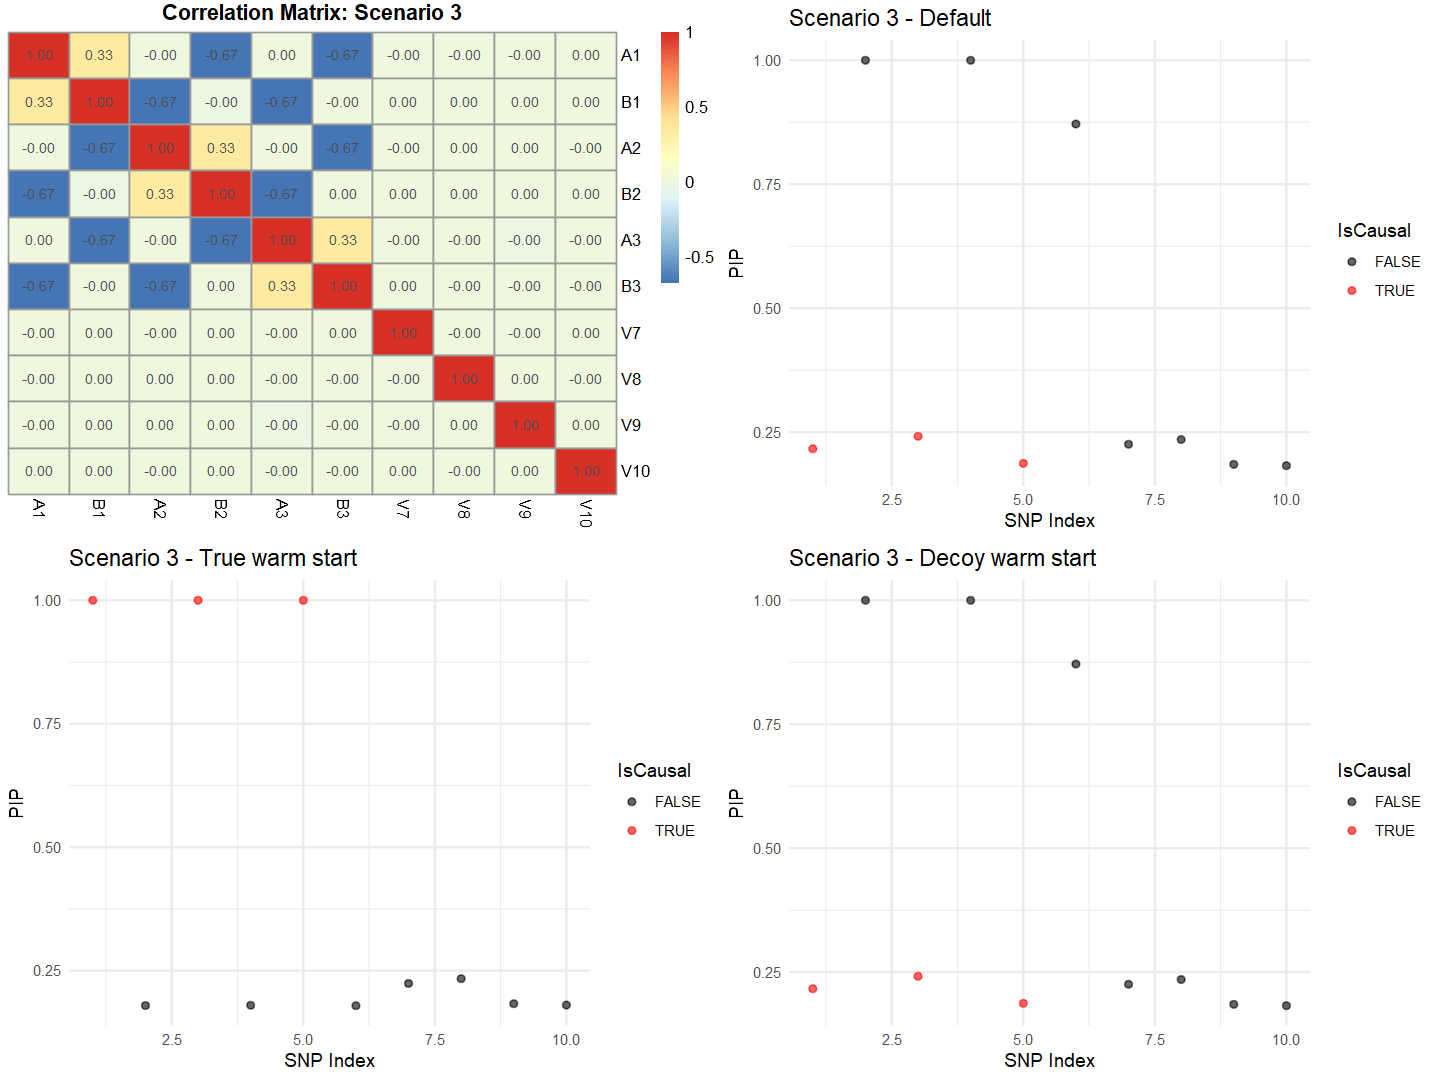

In [31]:
set.seed(42)
N <- 600; P <- 10; PVE <- 0.7

# Orthonormal basis A, then rotate via minimax Q to get B in same span
A <- qr.Q(qr(scale(matrix(rnorm(N * 3), N, 3), center = TRUE, scale = FALSE)))
Q <- diag(3) - (2/3) * matrix(1, 3, 3)
B <- A %*% Q

# Noise columns orthogonal to span(A)
Z0 <- scale(matrix(rnorm(N * 4), N, 4), center = TRUE, scale = FALSE)
Z0 <- Z0 - A %*% crossprod(A, Z0)

# Interleave A/B pairs + orthogonal noise
X3 <- scale(cbind(A[, 1], B[, 1], A[, 2], B[, 2], A[, 3], B[, 3], qr.Q(qr(Z0))))
colnames(X3) <- c("A1", "B1", "A2", "B2", "A3", "B3", "V7", "V8", "V9", "V10")
cat("Max abs pairwise correlation in X3:", max(abs(cor(X3)[upper.tri(cor(X3))])), "\n")

b3 <- c(1, -1, 0.5)
g3 <- X3[, c(1, 3, 5)] %*% b3
y3 <- g3 + rnorm(N, sd = sqrt(var(g3) * (1/PVE - 1)))

# b_decoy = Q^T b_true (exact equivalent coefficients for Mode B)
fit_scenario(X3, y3, g3, c(1, 3, 5), c(2, 4, 6), b3, "Scenario 3",
             L = 5, b_decoy = as.numeric(t(Q) %*% b3),
             estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)

## Scenario 4: The Greedy Trap (Optimizer Barrier)

Scenario 3 demonstrated a *model-specification* barrier: two equally valid basins that no single fit can jointly represent. Here we construct the complementary problem — an *optimizer* barrier where one basin is clearly better, but IBSS's greedy coordinate ascent gets stuck in the worse basin.

**Setup:** The true triplet $(V1, V3, V5)$ shares a latent factor ($\rho = 0.8$) and has coefficients $b = (1.2, -1.8, 0.6)$, which create partial cancellation in marginal associations (the positive and negative effects partially cancel when correlated with $y$ individually). The decoy triplet $(V2, V4, V6)$ consists of progressively noisier proxies of the true genetic signal $g = Xb$, designed to have *larger* marginal correlations with $y$ than the true variables, despite having *lower* joint explanatory power.

**The mechanism:** IBSS updates each single-effect component by regressing the current residual on each column of $X$. In the first pass, the decoy variables — which are correlated with the total signal $g$ rather than with individual causal effects — produce larger marginal statistics and get selected. Once a decoy is selected, the residual changes in a way that makes subsequent decoy selections self-reinforcing. The fit converges to a stable but suboptimal local optimum in the decoy basin.

The warm start at the true basin should achieve a substantially higher ELBO, confirming that a better basin exists but the greedy path misses it.

**Why multi-start selection is sufficient here:** Unlike Scenario 3, there is a single clearly dominant basin. Multi-start selection (random restarts or `refine`) just needs one initialization to land near the true basin. Once found, its higher ELBO ensures it is selected. No information is lost by discarding the decoy basin — it is genuinely worse.

**Why ensembling also works:** ELBO-softmax weighting will heavily upweight the true basin and downweight the decoy. The ensemble does not need to know which basin is correct — it just needs to discover it, and the ELBO does the rest. Ensembling is overkill for this scenario but does no harm, making it a safe default strategy that covers both optimizer barriers (Scenario 4) and model-specification barriers (Scenario 3).

Simulated PVE: 0.7161595 
Max |corr| (true): 0.2976 | (decoy): 0.7633 
Joint R2 true: 0.7216 | Joint R2 decoy: 0.5848 | PVE_joint_gap (true-decoy): 0.1368 

--- Credible Sets ( Default ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   176.9795         1         1        2

--- Credible Sets ( True warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1   448.3411         1         1        1
2  2  1033.0484         1         1        3
3  3   124.2752         1         1        5

--- Credible Sets ( Decoy warm start ) ---
  cs cs_log10bf cs_avg_r2 cs_min_r2 variable
1  1    176.969         1         1        2

ELBO (Default): -694.9326 
ELBO (True warm start): -587.0392 
ELBO (Decoy warm start): -694.9327 
ELBO gap (True - Default): 107.8934 
ELBO gap (Decoy - Default): -4.608267e-05 
Estimated 2-basin ensemble weights (ELBO-softmax): True = 1 | Decoy = 0 
Default decoy-dominant failure: TRUE 


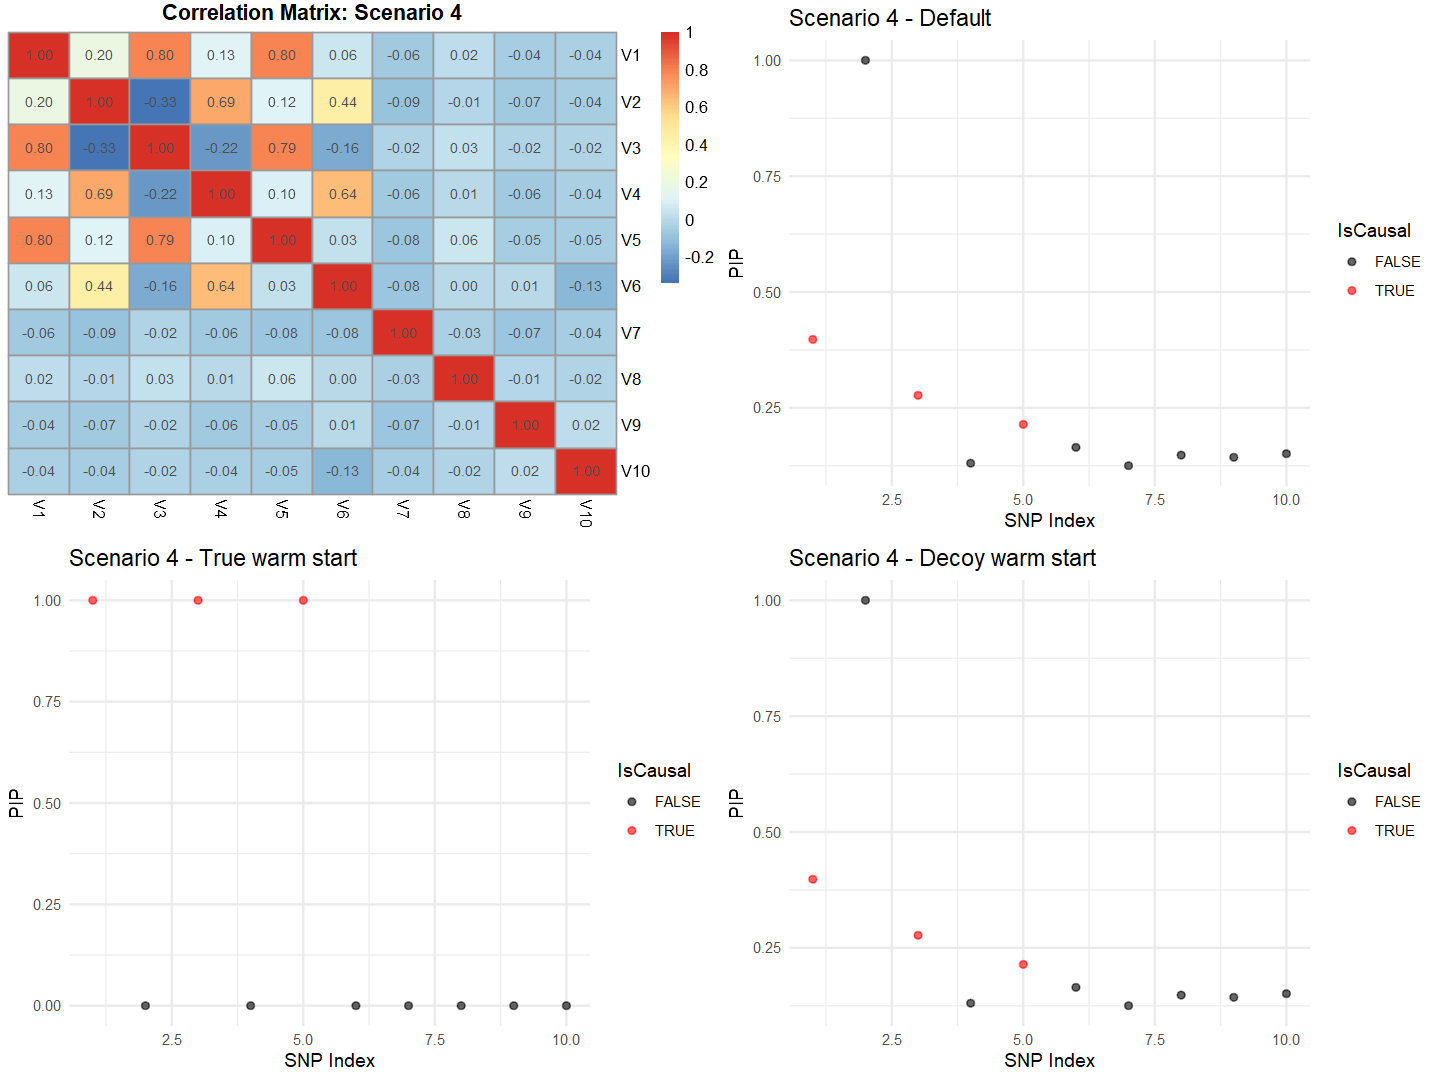

In [32]:
set.seed(123)
N <- 600; P <- 10; PVE <- 0.70
true_idx <- c(1, 3, 5); decoy_idx <- c(2, 4, 6)
beta_true <- c(1.2, -1.8, 0.6)

# True triplet: shared latent factor (rho=0.8)
f <- rnorm(N)
X_true <- scale(sqrt(0.8) * f + sqrt(0.2) * matrix(rnorm(N * 3), N, 3))

# Decoy triplet: noisy proxies of g_true (larger marginals, lower joint R2)
g_true <- as.numeric(scale(X_true %*% beta_true))
d1 <- as.numeric(scale(g_true + 0.50 * rnorm(N)))
d2 <- as.numeric(scale(d1 + 1.00 * rnorm(N)))
d3 <- as.numeric(scale(d2 + 1.30 * rnorm(N)))

X4 <- scale(cbind(X_true[, 1], d1, X_true[, 2], d2, X_true[, 3], d3,
                  matrix(rnorm(N * 4), N, 4)))
colnames(X4) <- paste0("V", 1:P)
y4 <- g_true + rnorm(N, sd = sqrt(var(g_true) * (1/PVE - 1)))

fit_scenario(X4, y4, g_true, true_idx, decoy_idx, beta_true, "Scenario 4",
             L = 3, max_iter = 200)